In [2]:
import numpy as np
from scipy.interpolate import interp1d
import os
import matplotlib.pyplot as plt

In [3]:
def augment_with_speed_variation(imu_data, min_speed=0.8, max_speed=1.2):
    """
    Adds speed variations to IMU data by stretching or compressing along the time axis.

    Parameters:
        imu_data (numpy.ndarray): Original IMU data of shape (samples, timesteps, channels).
        min_speed (float): Minimum speed factor (e.g., 0.8 for 80% of the original speed).
        max_speed (float): Maximum speed factor (e.g., 1.2 for 120% of the original speed).

    Returns:
        numpy.ndarray: Augmented IMU data with the same shape as input.
    """
    num_samples, timesteps, channels = imu_data.shape
    augmented_data = []

    for sample in range(num_samples):
        speed_factor = np.random.uniform(min_speed, max_speed)
        new_timesteps = int(timesteps * speed_factor)

        # Interpolate the data to simulate speed changes
        interpolated_sample = []
        for channel in range(channels):
            time_original = np.linspace(0, 1, timesteps)
            time_new = np.linspace(0, 1, new_timesteps)
            interpolator = interp1d(time_original, imu_data[sample, :, channel], kind='linear')
            interpolated_channel = interpolator(time_new)
            interpolated_sample.append(interpolated_channel)

        interpolated_sample = np.stack(interpolated_sample, axis=1)

        # Resample back to the original number of timesteps
        resample_time = np.linspace(0, 1, timesteps)
        interpolated_time = np.linspace(0, 1, new_timesteps)
        resampled_sample = []
        for channel in range(channels):
            resampler = interp1d(interpolated_time, interpolated_sample[:, channel], kind='linear')
            resampled_channel = resampler(resample_time)
            resampled_sample.append(resampled_channel)

        augmented_data.append(np.stack(resampled_sample, axis=1))

    return np.array(augmented_data)

def augment_with_jitter_and_jerk(imu_data, jitter_std=0.05, jerk_magnitude=0.1):
    """
    Adds jitter and jerk to IMU data.

    Parameters:
        imu_data (numpy.ndarray): Original IMU data of shape (samples, timesteps, channels).
        jitter_std (float): Standard deviation of the Gaussian noise added as jitter.
        jerk_magnitude (float): Magnitude of the jerk added as a sudden change to the data.

    Returns:
        numpy.ndarray: Augmented IMU data with the same shape as input.
    """
    # Add jitter (Gaussian noise)
    jitter = np.random.normal(loc=0.0, scale=jitter_std, size=imu_data.shape)
    augmented_data = imu_data + jitter

    # Add jerk (random spikes in the data)
    jerk_mask = np.random.choice([0, 1], size=imu_data.shape, p=[0.99, 0.01])  # Sparse jerks
    jerk = jerk_mask * np.random.uniform(-jerk_magnitude, jerk_magnitude, size=imu_data.shape)
    augmented_data += jerk

    return augmented_data

def augment_with_planar_rotation(imu_data, angle_range=(-10, 10)):
    """
    Adds planar rotation to IMU data by rotating accelerometer and gyroscope data in a specified plane.

    Parameters:
        imu_data (numpy.ndarray): Original IMU data of shape (samples, timesteps, channels).
        angle_range (tuple): Range of rotation angles in degrees.

    Returns:
        numpy.ndarray: Augmented IMU data with the same shape as input.
    """
    angle = np.radians(np.random.uniform(angle_range[0], angle_range[1]))
    cos_theta = np.cos(angle)
    sin_theta = np.sin(angle)

    rotation_matrix = np.array([
        [cos_theta, -sin_theta, 0],
        [sin_theta, cos_theta, 0],
        [0, 0, 1]
    ])

    augmented_data = []
    for sample in imu_data:
        accel = sample[:, :3] @ rotation_matrix.T
        gyro = sample[:, 3:] @ rotation_matrix.T
        augmented_data.append(np.hstack((accel, gyro)))

    return np.array(augmented_data)

def augment_imu_data(imu_data, min_speed=0.8, max_speed=1.2, jitter_std=0.05, jerk_magnitude=0.1, angle_range=(-10, 10)):
    """
    Combines speed variations, jitter, jerk, and planar rotation to augment IMU data.

    Parameters:
        imu_data (numpy.ndarray): Original IMU data of shape (samples, timesteps, channels).
        min_speed (float): Minimum speed factor for speed variation.
        max_speed (float): Maximum speed factor for speed variation.
        jitter_std (float): Standard deviation of the Gaussian noise added as jitter.
        jerk_magnitude (float): Magnitude of the jerk added as a sudden change to the data.
        angle_range (tuple): Range of rotation angles in degrees.

    Returns:
        numpy.ndarray: Augmented IMU data with the same shape as input.
    """
    # Apply speed variation
    imu_data = augment_with_speed_variation(imu_data, min_speed, max_speed)

    # Apply jitter and jerk
    imu_data = augment_with_jitter_and_jerk(imu_data, jitter_std, jerk_magnitude)

    # Apply planar rotation
    imu_data = augment_with_planar_rotation(imu_data, angle_range)

    return imu_data

def compare_statistics(original_data, augmented_data):
    for i in range(original_data.shape[2]):
        print(f"Channel {i+1}:")
        print(f"  Original Mean: {np.mean(original_data[:, :, i]):.4f}")
        print(f"  Augmented Mean: {np.mean(augmented_data[:, :, i]):.4f}")
        print(f"  Original Std: {np.std(original_data[:, :, i]):.4f}")
        print(f"  Augmented Std: {np.std(augmented_data[:, :, i]):.4f}\n")



def plot_sample(original_data, augmented_data, sample_idx=0, channel_idx=0):
    plt.figure(figsize=(12, 6))
    plt.plot(original_data[sample_idx, :, channel_idx], label="Original")
    plt.plot(augmented_data[sample_idx, :, channel_idx], label="Augmented")
    plt.title(f"Sample {sample_idx} - Channel {channel_idx}")
    plt.legend()
    plt.show()

In [13]:
# Load original IMU data and labels
imu_data = np.load('dataset/blind_user/data_20_120.npy')
labels = np.load('dataset/blind_user/label_20_120.npy')

# Use 60% of data for augmentation
num_samples = imu_data.shape[0]
num_augment_samples = int(num_samples * 0.6)
augment_data = imu_data[:num_augment_samples]
augment_labels = labels[:num_augment_samples]

# Generate 5x augmented data and corresponding labels
augmented_imu_data_list = []
augmented_labels_list = []

for i in range(8):
    augmented_data = augment_imu_data(augment_data)
    augmented_imu_data_list.append(augmented_data)
    augmented_labels_list.append(augment_labels)

augmented_imu_data = np.concatenate(augmented_imu_data_list, axis=0)
augmented_labels = np.concatenate(augmented_labels_list, axis=0)

# Ensure output directory exists
output_dir = 'dataset/augmented_data'
os.makedirs(output_dir, exist_ok=True)
augmented_data_path = os.path.join(output_dir, 'data_20_120.npy')
augmented_labels_path = os.path.join(output_dir, 'label_20_120.npy')

# Save the augmented data and labels
np.save(augmented_data_path, augmented_imu_data)
np.save(augmented_labels_path, augmented_labels)

# Save the remaining 40% for testing
test_dir = 'dataset/test_data'
test_data = imu_data[num_augment_samples:]
test_labels = labels[num_augment_samples:]
test_data_path = os.path.join(test_dir, 'data_20_120.npy')
test_labels_path = os.path.join(test_dir, 'label_20_120.npy')
np.save(test_data_path, test_data)
np.save(test_labels_path, test_labels)

print(f"Augmented IMU data saved to: {augmented_data_path}")
print(f"Augmented labels saved to: {augmented_labels_path}")
print(f"Test data saved to: {test_data_path}")
print(f"Test labels saved to: {test_labels_path}")

Augmented IMU data saved to: dataset/augmented_data/data_20_120.npy
Augmented labels saved to: dataset/augmented_data/label_20_120.npy
Test data saved to: dataset/test_data/data_20_120.npy
Test labels saved to: dataset/test_data/label_20_120.npy


In [14]:
#shape of augmented data

print(augmented_imu_data.shape)

(6904, 120, 6)


Channel 1:
  Original Mean: -0.0883
  Augmented Mean: 0.1023
  Original Std: 2.8572
  Augmented Std: 3.0423

Channel 2:
  Original Mean: -1.7876
  Augmented Mean: -1.6632
  Original Std: 2.9641
  Augmented Std: 2.8738

Channel 3:
  Original Mean: 4.4221
  Augmented Mean: 4.3431
  Original Std: 4.4990
  Augmented Std: 4.3788

Channel 4:
  Original Mean: -0.0016
  Augmented Mean: -0.0032
  Original Std: 0.8143
  Augmented Std: 0.7620

Channel 5:
  Original Mean: 0.0050
  Augmented Mean: 0.0077
  Original Std: 0.5928
  Augmented Std: 0.5878

Channel 6:
  Original Mean: -0.0020
  Augmented Mean: -0.0017
  Original Std: 0.5392
  Augmented Std: 0.5397



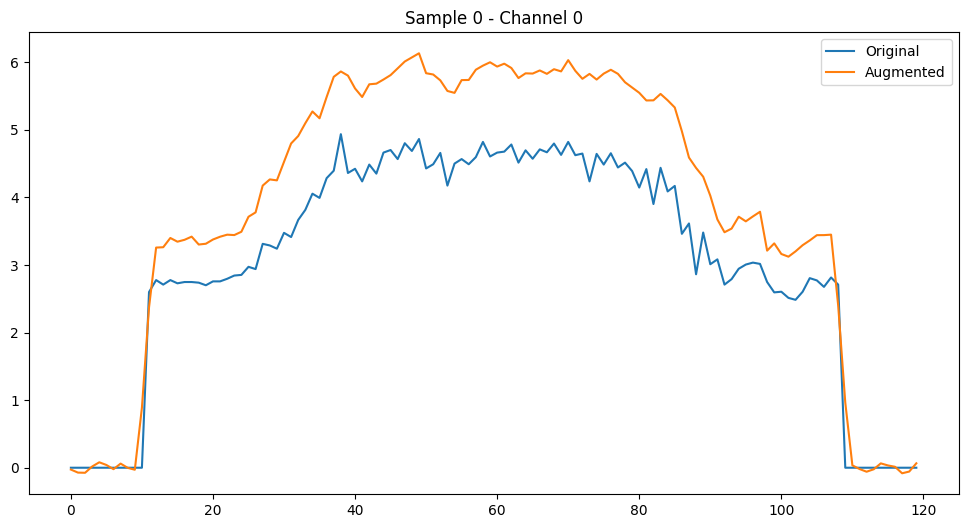

In [9]:
compare_statistics(imu_data, augmented_imu_data)
plot_sample(imu_data, augmented_imu_data, sample_idx=0, channel_idx=0)

In [ ]:
#